# Use PyMC Model for Bayes Hierarchical RL
- Estimate learning rate (i.e. alpha) for each subject using this model

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy
import os
# import stan

import pymc3 as pm
import arviz as az
# import learning package
#import DMpy

In [2]:
# read scr file
#scr = pd.read_csv('/media/Data/Lab_Projects/PTSD_Reversal/Behavioral/SCR3.csv')
scr = pd.read_csv('Behavioral/SCR3.csv')
scr.head()


,Event.Nr,CDA.nSCR,CDA.Latency,CDA.AmpSum,CDA.SCR,CDA.ISCR,CDA.PhasicMax,CDA.Tonic,TTP.nSCR,TTP.Latency,TTP.AmpSum,Global.Mean,Global.MaxDeflection,Event.NID,Event.Name,Condition,group,sub
0,1,5,0.8435,0.2852,0.0003,0.1339,8.1296,2.3324,1,3.9335,0.5884,2.4822,0.5884,5,5,CSplusUS1,HC,189
1,2,4,0.7335,0.1033,0.0012,0.4737,0.3046,4.0029,0,NaN,0.0000,4.3933,0.0000,5,5,CSminus1,HC,189
2,3,3,2.9835,0.0783,0.0008,0.3237,0.1352,3.9579,1,2.8335,0.0260,3.9900,0.0154,5,5,CSplus1,HC,189
3,4,1,3.4935,0.1772,0.0002,0.0993,7.0748,3.8756,1,3.5335,0.5186,3.9212,0.5186,5,5,CSplusUS1,HC,189
4,5,0,NaN,0.0000,0.0004,0.1532,0.1604,4.2513,0,NaN,0.0000,4.3461,0.0000,5,5,CSminus1,HC,189


In [3]:
scr = scr[['sub','Condition','Event.Nr','CDA.AmpSum']]
scr['sub'] = scr['sub'].astype('string')
for i in scr.iterrows():
    if len(i[1]['sub'])<=2:
        #print(i[1]['sub'])
        sub = 'sub-0' + str(i[1]['sub'])
    else:
        sub = 'sub-' + str(i[1]['sub'])
    #print(sub)
    scr.at[i[0], 'sub'] = sub
    

In [4]:
len(scr['sub'].unique())

101

In [5]:
# grab subjects with 69 trials
scr_clean = scr.copy() # make a copy of original
for sub in scr['sub'].unique():
    df = scr[scr['sub']==sub]
    #print (len(df))
    if len(df)<69:
        scr_clean = scr_clean[scr_clean['sub']!=sub]
        
len(scr_clean['sub'].unique()) # total of 86 valid subjects


86

In [6]:
# grab just two subjects for now
scrTwo = scr_clean#[(scr['sub']==152) |(scr['sub']==189) | (scr['sub']==86) | (scr['sub']==48)]
scrTwo['Event.Nr'].values

array([ 1,  2,  3, ..., 67, 68, 69])

Organize the data for the analysis

In [7]:
# organize data accordingly
# first, grab just the relevant variables (subject, trial, stimuli, shock)
# we need to generate a new variable shock (1=yes, 0=no)
# we also need a new variable stim (1=CS+, 2=CS-)
scrVec = scrTwo['CDA.AmpSum'].values
print(scrVec.shape)
shockVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture shock (1=yes, 0=no)
stimVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture stimulus (1=CS+, 2= CS-)

for i, cond in enumerate(scrTwo['Condition'].values):
    if cond=='CSplusUS1':
        shockVec[i]= 1
        stimVec[i] = 1
    elif cond=='CSminusUS2':
            # after reversal so minus becomes plus
        shockVec[i]= 1
        stimVec[i] = 0
    elif cond=='CSplus2':
            # after reversal so plus becomes minus
            shockVec[i]=0
            stimVec[i] = 1
    elif cond=='CSplus1':
            stimVec[i] = 1
            shockVec[i]= 0
    elif cond=='CSminus1':
            stimVec[i] = 0
            shockVec[i] = 0
    elif cond=='CSminus2':
        stimVec[i] = 0
        shockVec[i] = 0
    else:
        print(f' Condition is {cond}')
        stimVec[i] = 9
        shockVec[i] = 9
print(shockVec.shape)
print(stimVec.shape)

(5934,)
(5934,)
(5934,)


In [8]:
sum(shockVec) / sum(stimVec) 

0.38235294117647056

In [9]:
trialNo = [np.arange(5),np.arange(8)]
sub=2
t,s = np.meshgrid(trialNo, range(sub))
t


/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/numpy/lib/function_base.py:4360: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output = [np.asanyarray(x).reshape(s0[:i] + (-1,) + s0[i + 1:])


array([[array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4, 5, 6, 7])],
       [array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4, 5, 6, 7])]],
      dtype=object)

In [10]:
n_trials, n_subj = 69,len(scrTwo['sub'].unique())
trials, subj = np.meshgrid(range(n_trials), range(n_subj))

In [11]:
subj.T

array([[ 0,  1,  2, ..., 83, 84, 85],
       [ 0,  1,  2, ..., 83, 84, 85],
       [ 0,  1,  2, ..., 83, 84, 85],
       ...,
       [ 0,  1,  2, ..., 83, 84, 85],
       [ 0,  1,  2, ..., 83, 84, 85],
       [ 0,  1,  2, ..., 83, 84, 85]])

In [12]:
n_trials, n_subj = 69,len(scrTwo['sub'].unique())
trials, subj = np.meshgrid(range(n_trials), range(n_subj))

trials = tt.as_tensor_variable(trials.T)
subj = tt.as_tensor_variable(subj.T)
stim = np.reshape(stimVec, (n_subj,n_trials)).T # transform to matrix trials x subject
shock = np.reshape(shockVec, (n_subj,n_trials)).T 
scrMat = np.reshape(scrVec, (n_subj, n_trials)).T

In [13]:
stim = tt.as_tensor_variable(stim)
shock = tt.as_tensor_variable(shock)


# Build PyMC code

In [14]:
#scrs = tt.zeros(30) # set empty scr tensor (vector)
   
# generate functions to run
def update_Q(stim, shock,
             Qs,vec,
             alpha, n_subj):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
      
    PE = shock - Qs[tt.arange(n_subj), stim]
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + alpha * PE)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
    
    return Qs, vec, PE

def theano_llik_td(alpha,  stim, shock, n_subj):
   # stim = theano.shared(np.asarray(stim, dtype='int16'))
   # shock = theano.shared(np.asarray(shock, dtype='int16'))

    # Compute the Qs values
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    [Qs,vec, PE], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec, None],
        non_sequences=[alpha, n_subj])

       
    return Qs, vec, PE

In [12]:
with pm.Model() as m:
  
      
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 1, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec, pe], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock, None],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', mu = vec_, sd = eps, observed=scrMat) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    # add PE
    pe = pm.Deterministic('pe', pe)
    
    tr = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
az.plot_trace(tr, var_names='alpha')

In [14]:
az.summary(tr, var_names='alpha')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.004,0.014,0.000,0.011,0.001,0.000,4366.0,2030.0,1.00
alpha[1],0.461,0.292,0.000,0.933,0.005,0.004,2689.0,1263.0,1.00
alpha[2],0.970,0.027,0.919,1.000,0.000,0.000,3167.0,1999.0,1.00
alpha[3],0.074,0.205,0.000,0.575,0.016,0.011,356.0,357.0,1.01
alpha[4],0.127,0.057,0.038,0.235,0.001,0.001,4857.0,2426.0,1.00
...,...,...,...,...,...,...,...,...,...
alpha[81],0.002,0.002,0.000,0.005,0.000,0.000,4341.0,2066.0,1.00
alpha[82],0.342,0.114,0.161,0.572,0.008,0.006,341.0,92.0,1.01
alpha[83],0.004,0.004,0.000,0.011,0.000,0.000,4844.0,2489.0,1.00
alpha[84],0.002,0.002,0.000,0.007,0.000,0.000,3578.0,1791.0,1.00


# Add intercept

In [ ]:
# try alpha as beta distribution
with pm.Model() as m2:
  
    intercept = pm.Normal('intercept', 0,.5, shape=n_subj)  
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, .5, shape=n_subj)
    eps = pm.HalfNormal('eps', 1)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept[subj] + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    trI = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.summary(trI)

In [ ]:
az.compare({'model1': tr, 'model2_intercept':trI}) 

# Set intercept as all subjects

In [ ]:
with pm.Model() as m3:
  
    intercept = pm.Normal('intercept', 0,.5)  
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, .5, shape=n_subj)
    eps = pm.HalfNormal('eps', 1)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    tr3 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.summary(tr3)

In [ ]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3}) 

# Joint Slope

In [ ]:
with pm.Model() as m4:
  
    intercept = pm.Normal('intercept', 0,.5,  shape=n_subj)  
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, .5)
    eps = pm.HalfNormal('eps', 1)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept[subj] + vec[trials, subj,0] * beta
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    tr4 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.summary(tr4)

In [ ]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3,
           'model4_jointBeta':tr4}) 

# Both intercept and slope are joined

In [ ]:
with pm.Model() as m5:
  
    intercept = pm.Normal('intercept', 0,.5)  
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, .5)
    eps = pm.HalfNormal('eps', 1)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept + vec[trials, subj,0] * beta
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    tr5 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.summary(tr5)

In [ ]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3,
           'model4_jointBeta':tr4, 'model5': tr5}) 

## Use reparametarization on $\alpha$

In [ ]:
with pm.Model() as m_pooled:
    
    intercept = pm.Normal('intercept', 0, 2)
    alpha_mu = pm.Beta('alpha_mu', 1, 1)
    alpha_sd = pm.HalfNormal('alpha_sd',.5)
    alpha_matt = pm.Normal('alpha_matt', mu=0, sd=1, shape=n_subj)
    alpha = pm.Deterministic('alpha', alpha_mu + alpha_sd * alpha_matt)
    beta = pm.Normal('beta',0, 5, shape= n_subj)
    eps = pm.HalfNormal('eps', 5)
  
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    trH_1 = pm.sample(target_accept=.9, chains=4, cores=8, return_inferencedata=True)

In [ ]:
az.summary(trH_1)

In [ ]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3,
           'model4_jointBeta':tr4, 'model5': tr5, 'pooledAlpha':trH_1}) 

# Pooling intercet , slope and alpha

In [ ]:
with pm.Model() as m_pooled2:
    
    intercept_mu = pm.Normal('intercept_mu', 0, 1)
    intercept_sd = pm.HalfNormal('intercept_sd',5)
    intercept_matt = pm.Normal('alpha_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',intercept_mu + intercept_sd * intercept_matt)
    
    alpha = pm.Beta('alpha', 1, 1, shape = n_subj)
   
    beta_mu = pm.Normal('beta_mu', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta_matt = pm.Normal('beta_matt', 0,1, shape=n_subj)
    beta = pm.Deterministic('beta', beta_mu + beta_sd*beta_matt)
    eps = pm.HalfNormal('eps', 5)
  
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept[subj] + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    trH_2 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3,
           'model4_jointBeta':tr4, 'model5': tr5, 'pooledAlpha':trH_1, 'fully_pooled':trH_2}) 

# Similar to Stan model

In [ ]:
with pm.Model() as m_stan:
    mu = pm.Normal('mu', 0, 1, shape=3)
    sd = pm.HalfNormal('sd',5, shape=3)
     
    intercept_matt = pm.Normal('intercept_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',intercept_matt + mu[1]*sd[1] )
    
    
    alpha_h = pm.Beta('alpha_h',1,  1, shape = n_subj)
    alpha = pm.Deterministic('alpha', alpha_h + mu[0]* sd[0])
    
    
    beta_matt = pm.Normal('beta_matt',0, 1, shape=n_subj)
    beta = pm.Deterministic('beta', beta_matt + mu[2]*sd[2])
    
    eps = pm.HalfNormal('eps', 5)
  
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept[subj] + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    trH_Stan = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

# Model using hyperparameter in different way
- For reference:
https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/hierarchical_partial_pooling.html

In [16]:
with pm.Model() as m5:
    
    # α
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))
    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # β
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec, pe], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec, None],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    # add PE
    pe = pm.Deterministic('pe', pe)
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    #trH_phi = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

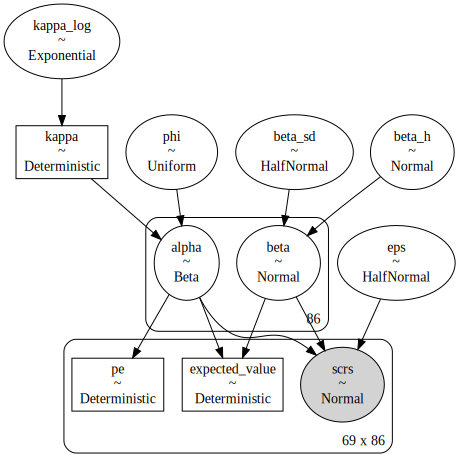

In [19]:
pm.model_to_graphviz(m5)

In [15]:
#trH_phi.to_netcdf('trH_phi.nc') # saving the trace
# loading
trH_phi = az.from_netcdf("trH_phi.nc")

In [13]:
az.summary(trH_phi)

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_ch

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_h,1.478,0.176,1.139,1.808,0.003,0.002,4746.0,2981.0,1.0
beta[0],1.548,0.122,1.310,1.771,0.002,0.001,5555.0,2904.0,1.0
beta[1],1.438,0.206,1.062,1.825,0.003,0.002,4463.0,2930.0,1.0
beta[2],3.490,0.195,3.122,3.862,0.004,0.002,3069.0,2538.0,1.0
beta[3],1.446,0.200,1.086,1.828,0.003,0.002,4314.0,3140.0,1.0
...,...,...,...,...,...,...,...,...,...
"pe[68,81]",-0.201,0.110,-0.402,-0.000,0.002,0.002,2319.0,1313.0,1.0
"pe[68,82]",-0.487,0.015,-0.500,-0.460,0.000,0.000,3234.0,1726.0,1.0
"pe[68,83]",-0.221,0.096,-0.399,-0.005,0.002,0.001,3379.0,1859.0,1.0
"pe[68,84]",-0.196,0.046,-0.273,-0.106,0.001,0.001,3185.0,2304.0,1.0


In [22]:
az.compare({'simpleModel':tr, 'hierarchy':trH_phi})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more r

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
hierarchy,0,-3636.783881,162.937412,0.000000,1.0,130.564955,0.000000,True,log
simpleModel,1,-4334.706620,200.268156,697.922739,0.0,187.655711,59.219443,True,log


### Same but with intercept

In [ ]:
with pm.Model() as m5_intercept:
    
    # intercept
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',5) 
    intercept_matt = pm.Normal('intercept_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',intercept_matt + mu*sd)
    
    # \alpha
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))
    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # \beta
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    trH_phi2 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.summary(trH_phi2)

In [ ]:
comp = az.compare({'model1': trH_phi, 'model2':trH_phi2}, ic='loo')
comp

In [ ]:
az.plot_compare(comp, insample_dev=False);

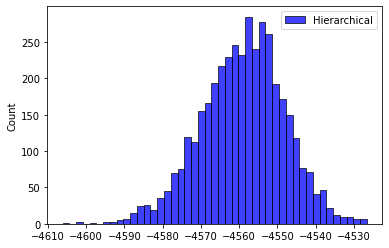

In [18]:
# calculate logP
# calculate logP
logP = trH_phi.sample_stats.lp.stack(draws=('chain','draw'))
#logP1 = tr.sample_stats.lp.stack(draws=('chain','draw'))
sns.histplot(logP, label='Hierarchical', color='blue')
#sns.histplot(logP1, label='Non Hierarchical', color='purple')
plt.legend()
#plt.vlines(np.mean(logP), 0, 250, color='red')

# Correlate with actual data

In [16]:
# grab alphas
alphas = trH_phi.posterior.stack(draws=('chain','draw'))
alphas = np.mean(alphas.alpha, axis=1)
alphas = pd.DataFrame({'subject': scr_clean['sub'].unique(), 'alphas':alphas })
alphas

,subject,alphas
0,sub-189,0.001360
1,sub-086,0.092429
2,sub-205,0.859179
3,sub-071,0.193670
4,sub-087,0.061154
...,...,...
81,sub-010,0.244547
82,sub-158,0.001376
83,sub-083,0.193163
84,sub-126,0.299816


In [17]:
# stack all chains
a = trH_phi.posterior.stack(draws=('chain','draw'))
a = a.expected_value
a.shape

(69, 86, 4000)

In [18]:
mean_a = np.mean(a, axis=2)
mean_a.shape

(69, 86)

In [19]:
# grab Prediction error
mean_pe = trH_phi.posterior.stack(draws=('chain','draw')).pe
mean_pe = np.mean(mean_pe, axis=2)


In [20]:
# calculate 
for i in np.arange(n_subj):
    cor1 = scipy.stats.pearsonr(scrMat[:,i], mean_a[:,i])
    print(cor1)

(-0.3327834825759949, 0.005207388444929092)
(0.5831998563206628, 1.4521840246079828e-07)
(0.9575765541901455, 6.352106430895376e-38)
(0.5437954324871666, 1.3726059462435658e-06)
(0.4142749563706875, 0.00040197953156067965)
(0.7131969193846922, 6.162938128072017e-12)
(0.38752222735415354, 0.0010027449740324312)
(0.1727262239372838, 0.15582549408090965)
(0.5496907853739743, 9.98789791462173e-07)
(0.41237175499392636, 0.0004300800420841049)
(0.31838540224388057, 0.007672349596629393)
(0.7363793365098348, 5.570858358133675e-13)
(0.6148722159029519, 1.9013991816776548e-08)
(0.22705653448927926, 0.06062746100662244)
(0.429772299148344, 0.0002284003640681991)
(0.05218003946990669, 0.6702449900260334)
(0.44104722067845603, 0.0001487750057855243)
(0.5666214666186339, 3.8716961855409807e-07)
(0.5284920612271848, 3.0476301345529563e-06)
(0.7027026126109513, 1.6956129538971336e-11)
(0.5983375679013112, 5.648459021475032e-08)
(0.3457499530789697, 0.0036158572205244525)
(0.4555943665195084, 8.366247

In [21]:
# seems that some subjects are really problematic. 
# should consider removing them from analysis
scr_clean['sub'].unique()
mean_a_vec = np.reshape(mean_a.T, (69*86,1)) # reshape to fit dataframe
mean_pe_vec = np.reshape(mean_pe.T, (69*86,1)) # reshape PE

In [22]:
len(scr_clean)
scr_clean['expected_value'] = mean_a_vec.values
scr_clean['pe'] = mean_pe_vec.values

In [23]:
scr_clean['scr'] = scr_clean['CDA.AmpSum']

In [24]:
# save file
scr_clean.to_csv('scr_clean.csv', index=False)

# Load brain data
Hippocampus - amygdala coupling

In [49]:
amg_hipp = pd.read_csv('dfSCR_coupling.csv')#('amg_hipp_fc_allTrials.csv')
amg_hipp

,index,subject,trialNo,condition,coupling,amg,Sub,group,Eprime,sub,Condition,Event.Nr,CDA.AmpSum,scr
0,0,sub-167,1,CSplusUS1,0.761905,-0.665134,sub-167,HC,A,sub-167,CSplusUS1,1,1.4637,1.4637
1,1,sub-167,2,CSminus1,-0.238095,-0.060757,sub-167,HC,A,sub-167,CSminus1,2,1.3764,1.3764
2,2,sub-167,3,CSplus1,0.095238,0.984678,sub-167,HC,A,sub-167,CSplus1,3,2.2023,2.2023
3,3,sub-167,4,CSplusUS1,0.523810,0.488085,sub-167,HC,A,sub-167,CSplusUS1,4,2.7164,2.7164
4,4,sub-167,5,CSminus1,-0.428571,0.053875,sub-167,HC,A,sub-167,CSminus1,5,2.3635,2.3635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4616,1720,sub-200,65,CSplus2,-0.023810,-0.128837,sub-200,HC,B,sub-200,CSplus2,65,0.0839,0.0839
4617,1721,sub-200,66,CSminus2,-0.500000,-0.126025,sub-200,HC,B,sub-200,CSminus2,66,0.9347,0.9347
4618,1722,sub-200,67,CSminus2,-0.119048,-0.097882,sub-200,HC,B,sub-200,CSminus2,67,0.5522,0.5522
4619,1723,sub-200,68,CSplus2,0.452381,0.117315,sub-200,HC,B,sub-200,CSplus2,68,0.0786,0.0786


In [50]:
vmpfc_amg = pd.read_csv('vmPFCcoupling.csv')
vmpfc_amg = vmpfc_amg.rename(columns={'coupling': 'amg_vmpfc'})
amg_hipp['amg_vmpfc'] = vmpfc_amg['amg_vmpfc'] # add this to amg hippocampus data

In [51]:
len(vmpfc_amg['amg_vmpfc'])

4621

In [52]:
sum(np.isnan(amg_hipp['amg_vmpfc']))

0

In [53]:
# add hippocampus anterior
hippAnt_amg = pd.read_csv('HippAntcoupling.csv')
hippAnt_amg = hippAnt_amg.rename(columns = {'coupling': 'amg_HippAnt'})
amg_hipp['amg_HippAnt'] = hippAnt_amg['amg_HippAnt']

In [60]:
# add control regions
ctrl_amg = pd.read_csv('controlROI.csv')
ctrl_amg = ctrl_amg.rename(columns = {'coupling': 'amg_ctrl'})
amg_hipp['amg_ctrl'] = ctrl_amg['amg_ctrl']

In [62]:
dfAll = pd.merge(scr_clean, amg_hipp)#, right_on=['subject','trialNo'], left_on=['sub','Event.Nr'])
dfAll.head()

,sub,Condition,Event.Nr,CDA.AmpSum,expected_value,pe,scr,index,subject,trialNo,condition,coupling,amg,Sub,group,Eprime,amg_vmpfc,amg_HippAnt,amg_ctrl
0,sub-189,CSplusUS1,1,0.2852,0.775073,0.500000,0.2852,1794,sub-189,1,CSplusUS1,0.309524,0.981121,sub-189,HC,A,0.904762,0.571429,0.523810
1,sub-189,CSminus1,2,0.1033,0.772940,-0.500000,0.1033,1795,sub-189,2,CSminus1,-0.571429,-0.027048,sub-189,HC,A,0.404762,-0.119048,0.404762
2,sub-189,CSplus1,3,0.0783,0.774003,-0.500680,0.0783,1796,sub-189,3,CSplus1,-0.476190,-0.045910,sub-189,HC,A,0.333333,-0.642857,0.119048
3,sub-189,CSplusUS1,4,0.1772,0.775070,0.500002,0.1772,1797,sub-189,4,CSplusUS1,0.166667,-0.674150,sub-189,HC,A,0.690476,0.357143,0.285714
4,sub-189,CSminus1,5,0.0000,0.771878,-0.499320,0.0000,1798,sub-189,5,CSminus1,0.214286,-0.065602,sub-189,HC,A,0.595238,0.309524,0.214286


In [63]:
sum(np.isnan(dfAll['amg_vmpfc']))

0

In [64]:
sum(np.isnan(dfAll['amg_ctrl']))

0

In [65]:
dfAll.to_csv('scr_amg_hipp_all.csv', index=False)

In [50]:
len(dfAll['sub'].unique())

65

In [35]:
# Statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
glm = smf.mixedlm('expected_value ~ coupling+ C(Condition) + amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    expected_value
No. Observations:    4485       Method:                REML          
No. Groups:          65         Scale:                 0.1633        
Min. group size:     69         Log-Likelihood:        -2475.5807    
Max. group size:     69         Converged:             Yes           
Mean group size:     69.0                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.369    0.062  5.968 0.000  0.248  0.491
C(Condition)[T.CSminus2]    0.213    0.029  7.421 0.000  0.157  0.269
C(Condition)[T.CSminusUS2]  0.510    0.030 17.123 0.000  0.452  0.568
C(Condition)[T.CSplus1]     0.196    0.021  9.568 0.000  0.156  0.236
C(Condition)[T.CSplus2]     0.027   

In [31]:
# assessing prediction error
glm_1 = smf.mixedlm('pe ~ coupling +  amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
model1_1 = glm_1.fit()
print(model1_1.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pe        
No. Observations: 4485    Method:             REML      
No. Groups:       65      Scale:              0.1748    
Min. group size:  69      Log-Likelihood:     -2522.8149
Max. group size:  69      Converged:          Yes       
Mean group size:  69.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.178    0.018 -9.699 0.000 -0.214 -0.142
coupling       0.084    0.016  5.300 0.000  0.053  0.115
amg           -0.014    0.015 -0.961 0.337 -0.043  0.015
trialNo       -0.001    0.000 -2.897 0.004 -0.002 -0.000
subject Var    0.011    0.006                           



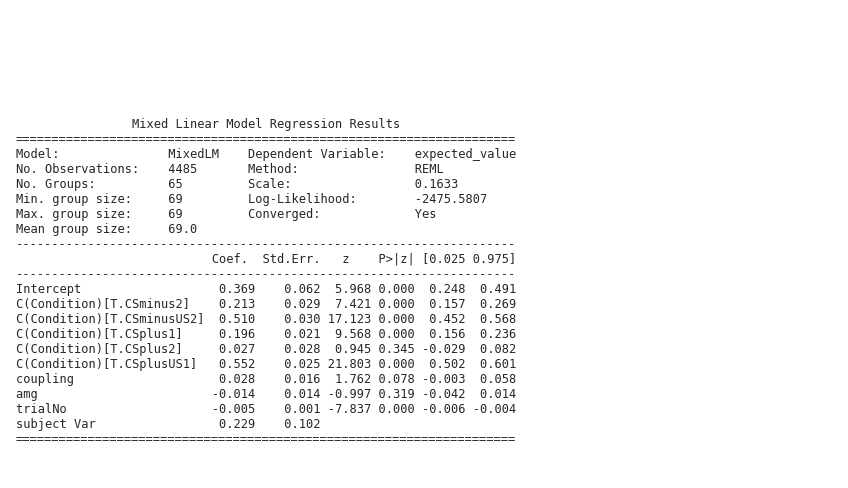

In [109]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model1.summary()), {'fontsize': 12}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig('outputEV_Coupling.png')

# Plotting results

(0.4261606814835369, 0.0002611977020820867)

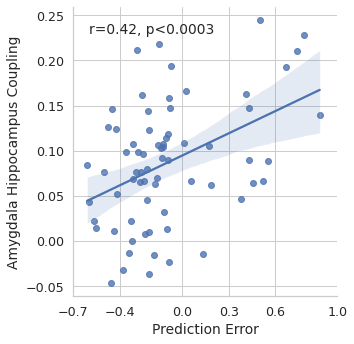

In [53]:
# plot results
forPlot = dfAll.groupby(['Event.Nr']).mean()
sns.set(font_scale = 1.15)
sns.set_style("whitegrid")
a = sns.lmplot(x ='pe', y='coupling', data= forPlot)
a.set_axis_labels("Prediction Error")
a.set_ylabels("Amygdala Hippocampus Coupling")
plt.text(-0.6,0.23, "r=0.42, p<0.0003")

a.set(xlim = (-0.7,0.95))
a.set(xticks=np.linspace(-0.7, 0.95, 6).round(1))
a.savefig('pe_coupling.png', dpi=300, bbox_inches='tight')
scipy.stats.pearsonr(forPlot['pe'], forPlot['coupling'])


# Do the same with VMPFC

In [33]:
glmVM = smf.mixedlm('expected_value ~ amg_vmpfc+ C(Condition) + amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
modelVM = glmVM.fit()
print(modelVM.summary())

                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    expected_value
No. Observations:    4000       Method:                REML          
No. Groups:          58         Scale:                 0.1642        
Min. group size:     67         Log-Likelihood:        -2291.3606    
Max. group size:     69         Converged:             Yes           
Mean group size:     69.0                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -1.163    0.218 -5.332 0.000 -1.591 -0.736
C(Condition)[T.CSminus2]    0.099    0.030  3.253 0.001  0.039  0.159
C(Condition)[T.CSminusUS2]  0.348    0.032 11.013 0.000  0.286  0.410
C(Condition)[T.CSplus1]     0.082    0.022  3.770 0.000  0.039  0.125
C(Condition)[T.CSplus2]     0.004   

In [36]:
glmVM_pe = smf.mixedlm('pe ~ amg_vmpfc+ amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
modelVM_pe = glmVM_pe.fit()
print(modelVM_pe.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pe        
No. Observations: 4485    Method:             REML      
No. Groups:       65      Scale:              0.1742    
Min. group size:  69      Log-Likelihood:     -2460.3354
Max. group size:  69      Converged:          Yes       
Mean group size:  69.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.126    0.014 -8.845 0.000 -0.154 -0.098
amg_vmpfc     -0.030    0.017 -1.774 0.076 -0.064  0.003
amg           -0.003    0.015 -0.200 0.841 -0.031  0.026
trialNo        0.001    0.000  4.172 0.000  0.001  0.002
subject Var    0.000    0.001                           



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(-0.2200474618395619, 0.06924810143540171)

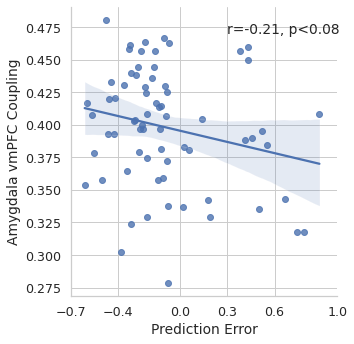

In [37]:
forPlot = dfAll.groupby(['Event.Nr']).mean()
sns.set(font_scale = 1.15)
sns.set_style("whitegrid")
a = sns.lmplot(x ='pe', y='amg_vmpfc', data= forPlot)
a.set_axis_labels("Prediction Error")
a.set_ylabels("Amygdala vmPFC Coupling")
plt.text(0.3,0.47, "r=-0.21, p<0.08")

a.set(xlim = (-0.7,0.95))
a.set(xticks=np.linspace(-0.7, 0.95, 6).round(1))
a.savefig('pe_VMPFCcoupling.png', dpi=300, bbox_inches='tight')
scipy.stats.pearsonr(forPlot['pe'], forPlot['amg_vmpfc'])


# Now with Amygdala-Anterior hippocampus

In [35]:
glmAH = smf.mixedlm('expected_value ~ amg_HippAnt+ C(Condition) + amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
modelAH = glmAH.fit()
print(modelAH.summary())

                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    expected_value
No. Observations:    4000       Method:                REML          
No. Groups:          58         Scale:                 0.1599        
Min. group size:     67         Log-Likelihood:        -2170.4388    
Max. group size:     69         Converged:             Yes           
Mean group size:     69.0                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.375    0.068  5.514 0.000  0.242  0.508
C(Condition)[T.CSminus2]    0.194    0.030  6.461 0.000  0.135  0.253
C(Condition)[T.CSminusUS2]  0.455    0.031 14.584 0.000  0.394  0.516
C(Condition)[T.CSplus1]     0.185    0.021  8.612 0.000  0.143  0.227
C(Condition)[T.CSplus2]     0.019   

In [38]:
glmAH_pe = smf.mixedlm('pe ~ amg_HippAnt+ amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
modelAH_pe = glmAH_pe.fit()
print(modelAH_pe.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pe        
No. Observations: 4485    Method:             REML      
No. Groups:       65      Scale:              0.1738    
Min. group size:  69      Log-Likelihood:     -2457.4252
Max. group size:  69      Converged:          Yes       
Mean group size:  69.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    -0.148    0.013 -11.271 0.000 -0.174 -0.122
amg_HippAnt   0.048    0.016   3.015 0.003  0.017  0.079
amg          -0.003    0.015  -0.233 0.816 -0.032  0.025
trialNo       0.001    0.000   3.975 0.000  0.001  0.002
subject Var   0.000    0.001                            



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(0.3726938656939413, 0.00161200479582876)

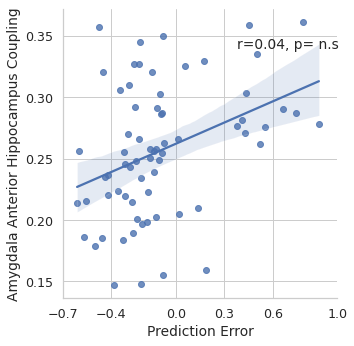

In [39]:
forPlot = dfAll.groupby(['Event.Nr']).mean()
sns.set(font_scale = 1.15)
sns.set_style("whitegrid")
a = sns.lmplot(x ='pe', y='amg_HippAnt', data= forPlot)
a.set_axis_labels("Prediction Error")
a.set_ylabels("Amygdala Anterior Hippocampus Coupling")
plt.text(0.38,0.34, "r=0.04, p= n.s")

a.set(xlim = (-0.7,0.95))
a.set(xticks=np.linspace(-0.7, 0.95, 6).round(1))
a.savefig('pe_AnteriorHippocampusCoupling.png', dpi=300, bbox_inches='tight')
scipy.stats.pearsonr(forPlot['pe'], forPlot['amg_HippAnt'])

In [44]:
# all hippocampus
glmH_pe = smf.mixedlm('pe ~ amg_HippAll+ amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
modelH_pe = glmH_pe.fit()
print(modelH_pe.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pe        
No. Observations: 4485    Method:             REML      
No. Groups:       65      Scale:              0.1743    
Min. group size:  69      Log-Likelihood:     -2462.0175
Max. group size:  69      Converged:          Yes       
Mean group size:  69.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    -0.138    0.013 -10.805 0.000 -0.163 -0.113
amg_HippAll   0.003    0.015   0.194 0.847 -0.027  0.033
amg          -0.002    0.015  -0.155 0.877 -0.031  0.026
trialNo       0.001    0.000   4.103 0.000  0.001  0.002
subject Var   0.000    0.001                            



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Summary:
- Amg-Hippocampus coupling is significantly predicting expected value!
- Amg - vmPFC is not

## Look at groups?

In [24]:
dfGroups = pd.read_csv('Behavioral/SubGroupLists.csv', dtype={'Sub': 'string'})
dfGroups = dfGroups[['Sub','group', 'Eprime']]
for i in dfGroups.iterrows():
    dfGroups.at[i[0], 'Sub'] = "sub-" + str(i[1].Sub)


,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,70,3.029728,0.05471,0.079667


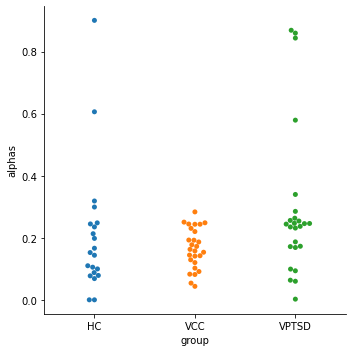

In [25]:
# test alphas and groups
alphas_b = pd.merge(alphas, dfGroups, left_on='subject', right_on='Sub')
sns.catplot(x='group',y='alphas', data=alphas_b, kind='swarm')
import pingouin as pg
pg.anova(data=alphas_b, between='group',dv='alphas')

In [59]:
alphas_b.to_csv('alphas_Reversal.csv', index=False)

In [56]:
alphas_b.groupby('group').describe()

alphas                                                              \
       count      mean       std       min       25%       50%       75%   
group                                                                      
HC      21.0  0.208158  0.206659  0.001360  0.088855  0.153389  0.245437   
VCC     27.0  0.167315  0.065382  0.044792  0.125626  0.163690  0.226055   
VPTSD   25.0  0.290834  0.239963  0.003587  0.172574  0.244900  0.263943   

                 
            max  
group            
HC     0.900137  
VCC    0.284189  
VPTSD  0.868347

In [57]:
pg.ttest(alphas_b['alphas'][alphas_b['group']=='VCC'], alphas_b['alphas'][alphas_b['group']=='VPTSD'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.489563,27.293869,two-sided,0.019172,"[-0.23, -0.02]",0.714778,3.315,0.71416


In [61]:
dfAll = pd.merge(dfAll, dfGroups, left_on='subject',right_on='Sub')
dfAll.head()

,sub,Condition,Event.Nr,CDA.AmpSum,expected_value,pe,scr,index,subject,trialNo,condition,coupling,amg,amg_vmpfc,amg_HippAnt,Sub,group,Eprime
0,sub-189,CSplusUS1,1,0.2852,0.775073,0.500000,0.2852,1794,sub-189,1,CSplusUS1,0.309524,0.981121,0.476190,0.285714,sub-189,HC,A
1,sub-189,CSminus1,2,0.1033,0.772940,-0.500000,0.1033,1795,sub-189,2,CSminus1,-0.571429,-0.027048,0.690476,-0.047619,sub-189,HC,A
2,sub-189,CSplus1,3,0.0783,0.774003,-0.500680,0.0783,1796,sub-189,3,CSplus1,-0.476190,-0.045910,0.285714,0.428571,sub-189,HC,A
3,sub-189,CSplusUS1,4,0.1772,0.775070,0.500002,0.1772,1797,sub-189,4,CSplusUS1,0.166667,-0.674150,0.547619,0.357143,sub-189,HC,A
4,sub-189,CSminus1,5,0.0000,0.771878,-0.499320,0.0000,1798,sub-189,5,CSminus1,0.214286,-0.065602,0.761905,-0.309524,sub-189,HC,A


In [62]:
# Statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
glm2 = smf.mixedlm('expected_value ~ coupling*C(group) + C(condition) + amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
model2 = glm2.fit()
print(model2.summary())

                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    expected_value
No. Observations:    4485       Method:                REML          
No. Groups:          65         Scale:                 0.1633        
Min. group size:     69         Log-Likelihood:        -2473.2532    
Max. group size:     69         Converged:             Yes           
Mean group size:     69.0                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.718    0.100  7.162 0.000  0.522  0.915
C(group)[T.VCC]            -0.496    0.131 -3.778 0.000 -0.753 -0.239
C(group)[T.VPTSD]          -0.490    0.137 -3.589 0.000 -0.758 -0.222
C(condition)[T.CSminus2]    0.213    0.029  7.426 0.000  0.157  0.269
C(condition)[T.CSminusUS2]  0.509   

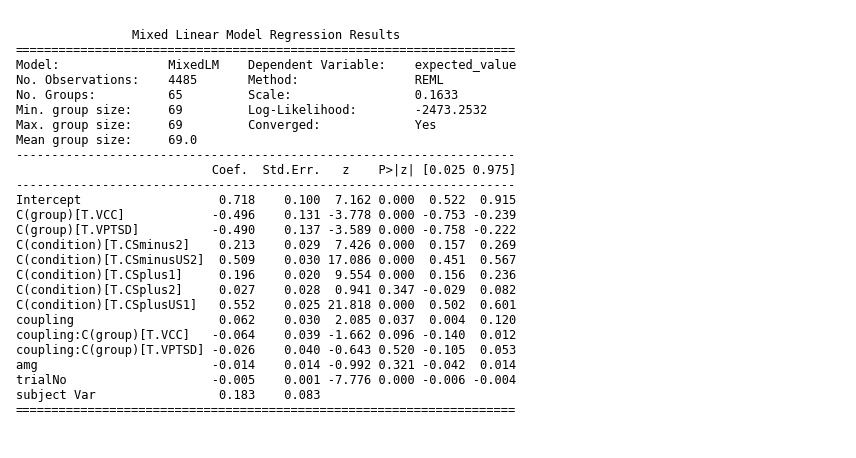

In [39]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model2.summary()), {'fontsize': 12}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig('outputEV_Coupling_groups.png')

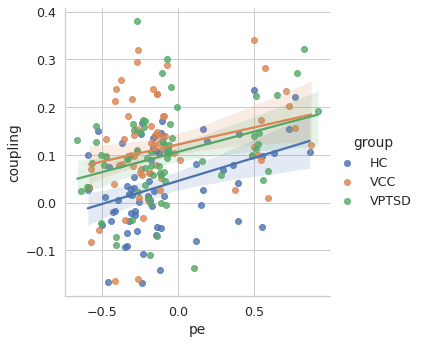

In [44]:
# using aggregate to summarize across groups
# this link is a nice reference: https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
dd = dfAll.groupby(['group', 'Event.Nr'], as_index=False).agg({'pe': 'mean', 'coupling':'mean'})

# plot
sns.lmplot(x='pe', y='coupling', hue='group', data=dd)

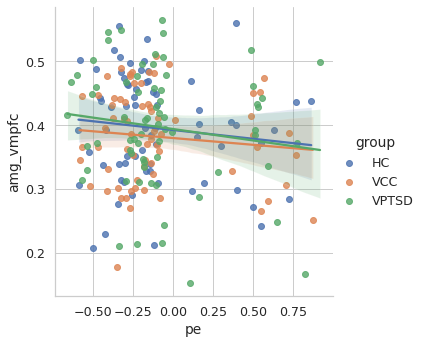

In [46]:
dd = dfAll.groupby(['group', 'Event.Nr'], as_index=False).agg({'pe': 'mean', 'amg_vmpfc':'mean'})
sns.lmplot(x='pe', y='amg_vmpfc', hue='group', data=dd)

# Implement mixed level model with pymc3

In [60]:
dfAll['subject'] = dfAll.subject.astype('category')
subIDX = dfAll.subject.cat.codes.values

In [61]:
subIDX

array([57, 57, 57, ..., 36, 36, 36], dtype=int8)

In [63]:
with pm.Model() as m:
    
    # linear mixed effects
    b = pm.Normal('b', 0,1, shape=n_subj) # intercept
    b2 = pm.Normal('b2', 0,1, shape=3) # effect of coupling[0], trialNo[1] and amygdala[2]
    sigma = pm.HalfNormal('sigms', 5)
  
  
    y = pm.Normal('y', b[subIDX] + b2[0]*dfAll.coupling + b2[1]*dfAll.trialNo + b2[2]*dfAll.amg,sigma,
                  observed=dfAll.pe)
    
    tr = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [sigms, b2, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [65]:
az.summary(tr, var_names='b2')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b2[0],0.088,0.016,0.059,0.118,0.0,0.0,6107.0,3124.0,1.0
b2[1],0.001,0.000,0.001,0.002,0.0,0.0,2966.0,3125.0,1.0
b2[2],-0.007,0.015,-0.033,0.022,0.0,0.0,8525.0,2801.0,1.0


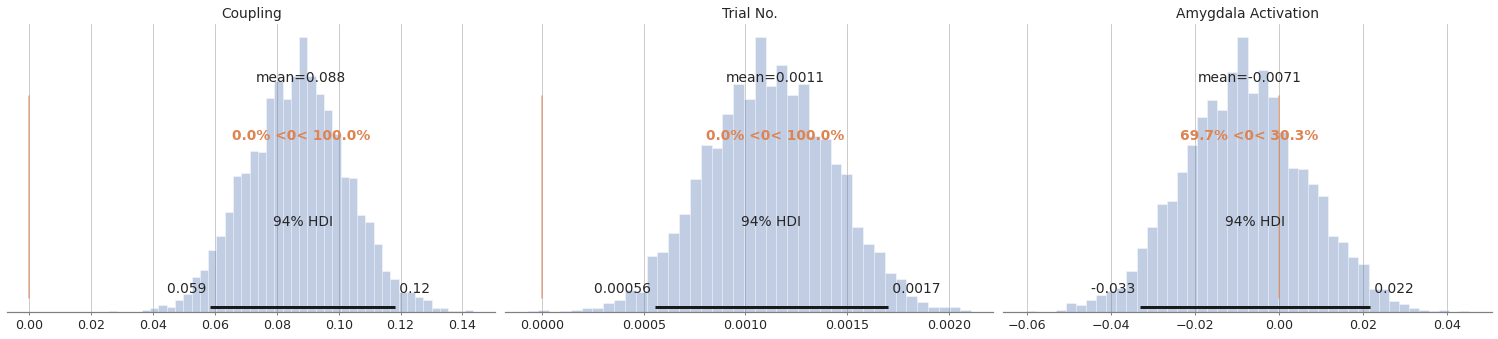

In [118]:
g = az.plot_posterior(tr, var_names='b2', kind='hist', ref_val=0)
g[0].title.set_text("Coupling")
g[1].title.set_text("Trial No.")
g[2].title.set_text("Amygdala Activation")

# Summary
- Coupling predicting changes

In [38]:
with m:
    ppc = pm.sample_posterior_predictive(tr)

In [ ]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=m), var_names='scrs')